In [226]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [227]:
#Get train and test data sets from torchvision.datsets using dataloader
#transform to tensor and normalize
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
#use above to get around SSl certificate expiring from cifar10 side

transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 5
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
#store class names for later
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

Files already downloaded and verified
Files already downloaded and verified


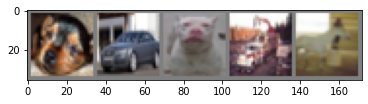

  dog automobile   dog truck horse


In [228]:
#show image function
def imgShow(img):
#unnormalise to better show image
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

#get 5 random training images (same as batch size)
dataiter = iter(trainloader)
images, labels = dataiter.next()

#show images
imgShow(torchvision.utils.make_grid(images))
#print labels
print(' '.join('%5s' % class_names[labels[j]] for j in range(batch_size)))

In [229]:
#check where network will be run
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [230]:
#create convolutional neural network CNNet class that takes 3-channel images like in CIFAR-10
class CNNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
# flatten all dimensions except batch
        x = torch.flatten(x, 1) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

cnnet = CNNet()

In [231]:
#Loss function and optimizer
criteria = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnnet.parameters(), lr=0.001, momentum=0.9)

In [232]:
#train network
#loop over the training dataset epoc number of times
for epoch in range(4):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
#get the inputs, training data is a list of inputs with labels
        inputs, labels = data
#zero parameter gradients
        optimizer.zero_grad()
#forward propogate, backwards propogate and optimize
        outputs = cnnet(inputs)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

#print statistics
        running_loss += loss.item()
#print every 2000 mini-batches
        if i % 2000 == 1999:    
            print('[epoch %d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Training complete')

[epoch 1,  2000] loss: 2.238
[epoch 1,  4000] loss: 1.856
[epoch 1,  6000] loss: 1.683
[epoch 1,  8000] loss: 1.569
[epoch 1, 10000] loss: 1.505
[epoch 2,  2000] loss: 1.459
[epoch 2,  4000] loss: 1.420
[epoch 2,  6000] loss: 1.392
[epoch 2,  8000] loss: 1.345
[epoch 2, 10000] loss: 1.321
[epoch 3,  2000] loss: 1.283
[epoch 3,  4000] loss: 1.245
[epoch 3,  6000] loss: 1.233
[epoch 3,  8000] loss: 1.214
[epoch 3, 10000] loss: 1.199
[epoch 4,  2000] loss: 1.139
[epoch 4,  4000] loss: 1.139
[epoch 4,  6000] loss: 1.142
[epoch 4,  8000] loss: 1.128
[epoch 4, 10000] loss: 1.088
Training complete


In [233]:
#how does it perform testing it across the whole testing dataset
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
#calculate outputs by running images through the network
        outputs = cnnet(images)
#the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on test image dataset: %d %%' % (
    100 * correct / total))

Accuracy of the network on test image dataset: 59 %


In [234]:
#55% is much better than a random 1/10
#what are the specific classes that performed well, and the classes that did not perform well
#prepare to count predictions for each class
correct_pred = {classname: 0 for classname in class_names}
total_pred = {classname: 0 for classname in class_names}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = cnnet(images)
        _, predictions = torch.max(outputs, 1)
#correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[class_names[label]] += 1
            total_pred[class_names[label]] += 1

#accuracy for each specific class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    
#how does changing epochs effects results
#1 epoch 47&
#2 epoc 55%
#3 epoc 57%
#4 epoc 59%
#5 epoc 60%
#6 epoc 63%
#7 epoc 62%
#8 epoc 63%
#9 epoc 61%
#10 epoc 63%

Accuracy for airplane is: 51.2 %
Accuracy for automobile is: 63.0 %
Accuracy for bird  is: 54.6 %
Accuracy for cat   is: 41.7 %
Accuracy for deer  is: 60.8 %
Accuracy for dog   is: 38.7 %
Accuracy for frog  is: 78.1 %
Accuracy for horse is: 50.4 %
Accuracy for ship  is: 80.1 %
Accuracy for truck is: 71.6 %
